In [150]:
from jqdatasdk import *
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
#倒入一些必要的库
auth('id','password') #ID是申请时所填写的手机号；Password为聚宽官网登录密码，新申请用户默认为手机号后6位
get_query_count()#当前剩余可用数据条数

{'spare': 965319, 'total': 1000000}

In [151]:
#get_industry_stocks('I64')# 获取计算机/互联网行业的成分股
#get_index_stocks('399951.XSHE', date=None)#获取沪深300银行指数成分股

In [152]:
#该函数能够获得指定时间，指定股票成分股的截面数据
def getdata(stock,datetime,gap):
    #调取截面数据、计算月收益率数据
    sample = get_index_stocks(stock, date=datetime)#股票除选择沪深300银行指数成分股
    q = query(valuation.code, 
              valuation.market_cap,#市值
              valuation.circulating_market_cap,
              balance.total_assets - balance.total_liability,#净资产
              balance.total_assets / balance.total_liability, 
              indicator.net_profit_to_total_revenue, #净利润/营业总收入
              indicator.inc_revenue_year_on_year,  #营业收入增长率（同比）
              balance.development_expenditure, #RD
              valuation.pe_ratio, #市盈率（TTM）
              valuation.pb_ratio, #市净率（TTM）
              indicator.inc_net_profit_year_on_year,#净利润增长率（同比）
              balance.dividend_payable,
              indicator.roe,
              indicator.roa,
              income.operating_profit / income.total_profit, #OPTP
              indicator.gross_profit_margin, #销售毛利率GPM
              balance.fixed_assets / balance.total_assets, #FACR
              valuation.pcf_ratio, #CFP
              valuation.ps_ratio #PS
            ).filter(
                valuation.code.in_(sample)
            )
    df = get_fundamentals(q, date =datetime)
    #df.index = df.code.values
    del df['code']
    df = df.fillna(0)
    
    #解决数据日期问题 选取未来一个月的日期
    year = int(datetime[:4])
    month = int(datetime[5:7])
    day=int(datetime[8:10])
    if month == 12:       
        nexttime = str(year+1)+'-'+str(gap)+'-'+str(day)
    else:  
        nexttime = str(year)+'-'+str(month+gap)+'-'+str(day)
        
    #构建特征和标签
    sample2 = get_index_stocks(stock, date=nexttime)#股票除选择沪深300银行指数成分股
    q2 = query(valuation.code, 
              valuation.market_cap,#市值
            ).filter(
                valuation.code.in_(sample2)
            )
    df2=get_fundamentals(q2, date = nexttime)
    del df2['code']
    monthreturn=pd.DataFrame(df2['market_cap'].values/df['market_cap'].values, columns=['monthreturn'])
    df=pd.concat([df,monthreturn],axis=1)
    #df即为我们的训练集 用来训练回归模型 筛选变量和权重
    return df

In [153]:
#构建一个日期表，从这些日期中选取截面数据
def return_datelist(start_date,end_date):
    datelist=[]
    #start_date:str, 初始日期
    #end_date:str,终止日期
    start_year = int(start_date[:4])
    end_year = int(end_date[:4])
    start_month = int(start_date[5:7])
    end_month = int(end_date[5:7])
    start_day=int(start_date[8:10])
    end_day=int(end_date[8:10])
    for i in range(end_month):
        if(end_month-i<10):
            date=str(end_year)+'-'+'0'+str(end_month-i)+'-'+str(end_day)
            datelist=datelist+[date]
        else:
            date=str(end_year)+'-'+str(end_month-i)+'-'+str(end_day)
            datelist=datelist+[date]
    for i in range(13-start_month):
        if(start_month+i<10):
            date=str(start_year)+'-'+'0'+str(start_month+i)+'-'+str(start_day)
            datelist=datelist+[date]
        else:
            date=str(start_year)+'-'+str(start_month+i)+'-'+str(start_day)
            datelist=datelist+[date]          
        current_year=start_year+1
    while(current_year!=end_year):
        for i in range(11):
            if(i+1<10):
                date=str(current_year)+'-'+'0'+str(i+1)+'-'+str(start_day)
                datelist=datelist+[date]
            else:
                date=str(current_year)+'-'+str(i+1)+'-'+str(start_day)
                datelist=datelist+[date]
        current_year=current_year+1
    return datelist    

In [154]:
#获得训练数据集
start_date='2011-01-15'
end_date='2015-10-15'
monthgap=1
datelist=return_datelist(start_date=start_date,end_date=end_date)
df=getdata(stock='399951.XSHE',datetime=start_date,gap=monthgap)
for i in datelist:
    dfnew=getdata(stock='399951.XSHE',datetime=i,gap=1)
    df=pd.concat([df,dfnew],axis=0)
df.shape

(896, 19)

In [155]:
#借助训练集进行回归模型的训练 归一化数据
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df1=min_max_scaler.fit_transform(df)
df2 = pd.DataFrame(df1, columns=df.columns)
df2.shape

(896, 19)

In [156]:
y=df2['monthreturn']
x=df2.drop(columns = ['monthreturn'])
x.shape,y.shape

((896, 18), (896,))

[-3.77933428e-02 -1.55410523e-02  3.45915659e-02  9.57118182e-02
 -7.97701635e-03  8.67343538e-02  1.59594560e-16 -7.55800571e-02
 -1.02128119e-01 -9.43221465e-02 -6.82583564e-03  2.24140271e-01
 -2.22377399e-01 -1.15697545e-02 -6.93889390e-17  1.41766901e-02
  2.33825464e-03  4.96848230e-03]


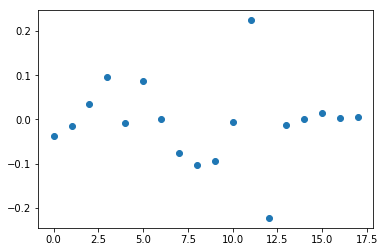

In [157]:
#利用线性模型得到权重
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(x, y)
print(lr.coef_)
plt.plot(lr.coef_,'o', label = 'linear regression')

[-0.01162734 -0.00419049  0.          0.12681069  0.00973815  0.07683682
  0.         -0.0425415  -0.06444428  0.          0.          0.18016636
 -0.18905393  0.17829171  0.          0.01567158  0.23441865 -0.05182311]


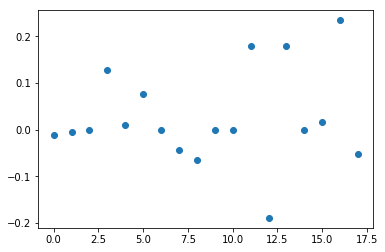

In [158]:
#利用线性模型得到权重
from sklearn.linear_model import Lasso
lasso = Lasso(fit_intercept=False)
lasso.set_params(alpha=0.0002)
lasso.fit(x, y)
print(lasso.coef_)
plt.plot(lasso.coef_,'o', label = 'linear regression')

[-0.01158481 -0.00611452 -0.         -0.01763291 -0.          0.03017785
  0.         -0.03793117 -0.07131147 -0.         -0.          0.
 -0.01458891  0.          0.         -0.         -0.         -0.03967986]


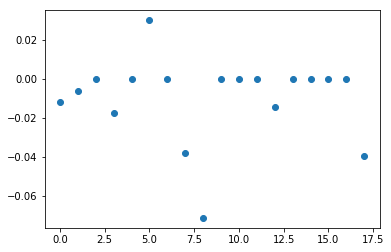

In [159]:
#利用线性模型得到权重
from sklearn.linear_model import ElasticNet
enet=ElasticNet(alpha=.005,l1_ratio=0.05)
enet.fit(x, y)
print(enet.coef_)
plt.plot(enet.coef_,'o', label = 'linear regression')

In [160]:
window=1
feanum=x.shape[1]
x=x.values
x=np.reshape(x, (x.shape[0],1, x.shape[1]))

In [200]:
#建立、训练模型过程
d = 0.01
model = Sequential()#建立层次模型
model.add(LSTM(16, input_shape=(window, feanum), return_sequences=True))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
model.add(LSTM(4, input_shape=(window, feanum), return_sequences=False))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
model.add(Dense(4,init='uniform',activation='relu'))   #建立全连接层     
model.add(Dense(1,init='uniform',activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.fit(x, y, nb_epoch =30, batch_size = 64) #训练模型nb_epoch次

E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="uniform")`
  
E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/30
896/896 [==============================] - 4s 4ms/step - loss: 0.1521 - acc: 0.0011 
Epoch 2/30
896/896 [==============================] - 0s 65us/step - loss: 0.1413 - acc: 0.0011
Epoch 3/30
896/896 [==============================] - 0s 63us/step - loss: 0.1297 - acc: 0.0011
Epoch 4/30
896/896 [==============================] - 0s 62us/step - loss: 0.1170 - acc: 0.0011
Epoch 5/30
896/896 [==============================] - 0s 71us/step - loss: 0.1027 - acc: 0.0011
Epoch 6/30
896/896 [==============================] - 0s 111us/step - loss: 0.0860 - acc: 0.0011
Epoch 7/30
896/896 [==============================] - 0s 75us/step - loss: 0.0669 - acc: 0.0011
Epoch 8/30
896/896 [==============================] - 0s 62us/step - loss: 0.0469 - acc: 0.0011
Epoch 9/30
896/896 [==============================] - 0s 80us/step - loss: 0.0295 - acc: 0.0011
Epoch 10/30
896/896 [==============================] - 0s 78us/step - loss: 0.0181 - acc: 0.0011
Epoch 11/30
896/896 [=================

In [201]:
#在训练集上的拟合结果
predict=model.predict(x)[:,0]

Text(0.5,1,'Train Data')

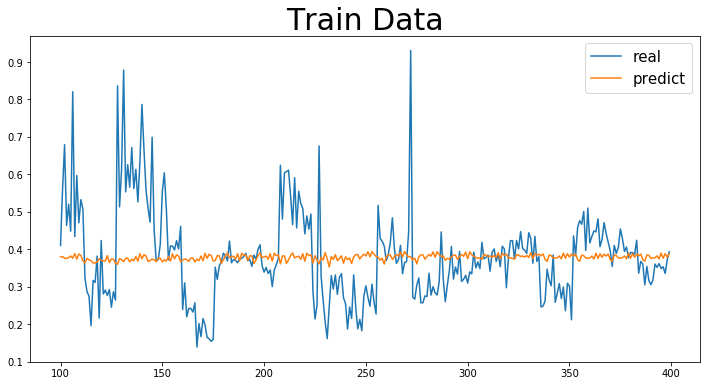

In [202]:
draw=pd.concat([pd.DataFrame(y.values),pd.DataFrame(predict)],axis=1)
draw.iloc[100:400,0].plot(figsize=(12,6))
draw.iloc[100:400,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
#展示在训练集上的表现 

In [203]:
#开始模拟投资 读取当天的相关截面数据 预测收益率 并对股票按收益率排序
sample3 = get_index_stocks('399951.XSHE', date=None)#股票除选择沪深300银行指数成分股
q3 = query(valuation.code, 
          valuation.market_cap,#市值
          valuation.circulating_market_cap,
          balance.total_assets - balance.total_liability,#净资产
          balance.total_assets / balance.total_liability, 
          indicator.net_profit_to_total_revenue, #净利润/营业总收入
          indicator.inc_revenue_year_on_year,  #营业收入增长率（同比）
          balance.development_expenditure, #RD
          valuation.pe_ratio, #市盈率（TTM）
          valuation.pb_ratio, #市净率（TTM）
          indicator.inc_net_profit_year_on_year,#净利润增长率（同比）
          balance.dividend_payable,
          indicator.roe,
          indicator.roa,
          income.operating_profit / income.total_profit, #OPTP
          indicator.gross_profit_margin, #销售毛利率GPM
          balance.fixed_assets / balance.total_assets, #FACR
          valuation.pcf_ratio, #CFP
          valuation.ps_ratio #PS
        ).filter(
            valuation.code.in_(sample3)
        )
df = get_fundamentals(q3,date=None)
df.index = df.code.values
del df['code']
df = df.fillna(0)

In [206]:
#实现预测+排序
min_max_scaler = preprocessing.MinMaxScaler()
df1=min_max_scaler.fit_transform(df)
df2 = pd.DataFrame(df1, columns=df.columns,index=df.index)
x=df2
x=x.values
x=np.reshape(x, (x.shape[0],1, x.shape[1]))
factor = pd.DataFrame(model.predict(x), index = df.index, columns = ['monthreturn'])
factor = factor.sort_index(by = 'monthreturn')#做了个排序
stockset = list(factor.index[:10])#选排名前十的股票

E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if __name__ == '__main__':


In [207]:
stockset

['600015.XSHG',
 '601988.XSHG',
 '601229.XSHG',
 '601998.XSHG',
 '600926.XSHG',
 '601818.XSHG',
 '600016.XSHG',
 '601169.XSHG',
 '601328.XSHG',
 '600919.XSHG']